<img src='./img/logoline_12000.png' align='center' width='100%'></img>

<br>

# CORDEX: Regional climate projections

### About

This notebook provides you a practical introduction to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). CORDEX data are available for 14 regional domains and variable spatial resolutions, from 0.11 x 0.11 degrees up to 0.44 x 0.44 degrees. This workflow shows you how to compute the difference of air temperature climatology for 2071-2100 relative to the reference period 1971-2000 in Africa, with a spatial resolution of 0.22 x 0.22 degrees. 

The workflow makes use of two CORDEX experiments: `historical` and `RCP4.5`. You will use the `historical` experiment to compute the climatology for the period 1971 to 2000 to the scenario `RCP4.5` to compute the future climatology for the period 2071 to 2100. 

The example showcases data from the Canadian Regional Climate Model `CCCma_CanRCM4`. See [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-DrivingGlobalClimateModelsandRegionalClimateModels) a full list of models included in the CDS-CORDEX subset.


In general, CORDEX experiments can be divided in three main categories:

**Evaluation**: model simulations for the past with imposed "perfect" lateral boundary condition following ERA-Interim reanalyses (1979-2015).

**Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the RCMs perform for the past climate when forced by the Global Circulation Model (GCM) and can be used as reference period for comparison with scenario runs for the future. 

**Scenario experiments RCP2.6, RCP4.5, RCP8.5**: ensemble of CORDEX climate projection experiments driven by boundary conditions from GCMs using RCP (Representative Concentration Pathways) forcing scenarios. The scenarios used here are RCP 2.6, 4.5 and 8.5, which provide different pathways of the future climate forcing.

Learn [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-Experiments) more about CORDEX experiments in the Copernicus Climate Data Store.



The notebook has the following outline:

* [1 - Unzip the downloaded data files](#unzip_cordex)
* [2 - Compute CORDEX historical climatology for reference period 1971-2000](#cordex_historical_climatology)
* [3 - Compute CORDEX future climatology for reference period 2071-2100 based on scenario RCP4.5](#cordex_future_climatology)
* [4 - Compute and visualize the near-surface air temperature difference between reference periods 2071-2100 and 1971-2000](#cordex_visualize_difference)

### Data

This notebook introduces you to `CORDEX regional climate model data` on single levels. The data used in the notebook has the following specifications:

> **Data**: `CORDEX regional climate model data on single levels - Experiment: Historical` <br>
> **Temporal coverage**: `1 Jan 1971 to 31 Dec 2000` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `zip`<br>
> **Retrieve requests**: [CDS API request - CORDEX regional climate model data - Experiment: Historical](./100_climate_data_store_intro.ipynb#cordex_historical)


<br>

> **Data**: `CORDEX regional climate model data on single levels - Experiment: RCP4.5` <br>
> **Temporal coverage**: `1 Jan 2071 to 31 Dec 2100` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `zip`<br>
> **Retrieve requests**: [CDS API request - CORDEX regional climate model data - Experiment: RCP 4.5](./100_climate_data_store_intro.ipynb#cordex_rcp45)

<br>


Get [here](./101_c3s_data_intro.ipynb#climate_projections) more information about climate projections in general including an overview of the different climate projections available in the Climate Data Store.

<hr>

### Load libraries

In [3]:
# CDS API
#import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Libraries for paths and filenames
from glob import glob
from pathlib import Path
from os.path import basename

### Load helper functions

In [4]:
%run ./functions.ipynb

<hr>

## <a id='unzip_cordex'></a>1. Unzip the downloaded data files

From the Copernicus Climate Data Store, CORDEX data are available either as compressed `zip` archive or compressed `tar.gz` archive. For this reason, before we can load any data, we have to unzip or untar the files. Once you downloaded the two experiments `historical` and `RCP4.5` as seperate zip files (see CDSAPI requests [here](./100_climate_data_store_intro.ipynb#climate_projections)), you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for the two zip files downloaded. You see that the actual data files are disseminated in `NetCDF`. CORDEX files organised in five year periods. For this reason, for each zip file, six `NetCDF` files in fiver year periods are extracted.

In [20]:
import zipfile
with zipfile.ZipFile('./data/cordex_regional_projection/1971-2000_cordex_rcp_4_5_africa.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cordex_regional_projection/historical/')

In [2]:
import zipfile
with zipfile.ZipFile('./data/cordex_regional_projection/2071-2100_cordex_rcp_4_5_africa.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cordex_regional_projection/projection/')

<br>

## <a id='cordex_historical_climatology'></a>2. Compute CORDEX historical climatology for reference period 1971-2000

The first step is to load the data of the `historical` experiment.

CORDEX data, once unzipped, are disseminated in `NetCDF`. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_mfdataset` to read multiple NetCDF files at once. With the keyword argument `concat_dim`, you can specify the dimension at which the data shall be concatenated on. In the case of the CORDEX data, since the data files are split based on years, you want to concatenate the data at the dimension `time`.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [5]:
ds_1971_2000_historical = xr.open_mfdataset('./data/cordex_regional_projection/historical/*.nc', concat_dim='time')
ds_1971_2000_historical

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 201, rlon: 194, time: 10950)
Coordinates:
  * time          (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon          (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(1825, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    history:                        created: 2012-06-29 23:52:08 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:47:03Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/3d35a8d3-105d-451c-88fa-4d46...
    c3s_disclaimer:                 This data has been curated and prepared i...

<br>

The next step is to load the data variable `tas` from the Dataset above. You can load a data variables by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [6]:
tas_1971_2000_historical = ds_1971_2000_historical['tas']
tas_1971_2000_historical

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)>
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1825, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

<br>

Let us inspect the time dimension. You can see that the time dimension has 10950 entries and represents daily data from 1 January 1971 to 31 December 2000.

In [7]:
tas_1971_2000_historical.time

<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(1971, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2000, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
    height   float64 2.0
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    bounds:         time_bnds

<br>

In a next step, we want to compute the monthly climatology for this reference period. The monthly climatology represents for each month the average value over the reference period of 30 years, from 1971 to 2000. You can compute the climatology with xarray in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, you can create the average of each group with the function mean().

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes from the DataArray.

In [8]:
tas_1971_2000_climatology = tas_1971_2000_historical.groupby('time.month').mean()
tas_1971_2000_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<stack, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

In a last step, we want to convert the near-surface air temperature values in Kelvin to degrees Celsisus. You can do this by subtracting 273.15 from air temperature values in Kelvin.

In [9]:
tas_1971_2000_climatology_degC = tas_1971_2000_climatology - 273.15
tas_1971_2000_climatology_degC

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

## <a id='cordex_future_climatology'></a>3. Compute CORDEX future climatology for reference period 2071-2100 based on scenario RCP4.5

Let us now repeat the steps executed for the historical experiment data with the `scenario RCP4.5` data. With the projection data for the time period 2071 to 2100, we can compute the future climatology which can be compared with the historical climatology.
You can use again the function `open_mfdataset()` to load multiple `NetCDF` files. The scenario data is also organised based on 5-year periods. Hence, the dimension to concatenate the data is `time`.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [10]:
ds_2071_2100_projection = xr.open_mfdataset('./data/cordex_regional_projection/projection/*.nc', concat_dim='time')
ds_2071_2100_projection

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 201, rlon: 194, time: 10950)
Coordinates:
  * time          (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
  * rlon          (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(1825, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     RCP4.5 run driven by CCCma-CanESM2 
    ...                             ...
    history:                        created: 2012-06-29 23:55:49 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:48:22Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/7bd05374-ef0d-4b0a-80fc-5e08...
    c3s_disclaimer:                 This data has been curated and prepared i...

<br>

The next step is to load the data variable `tas` from the Dataset above. You can load a data variables by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [11]:
tas_2071_2100_projection = ds_2071_2100_projection['tas']
tas_2071_2100_projection

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)>
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1825, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

<br>

Let us also inspect the time dimension for the projection data. The dimension has the same number of entries as the historical data, 10950. Hence, the scenario data are daily aggregates for the years 2071 to 2100.

In [6]:
tas_2071_2100_projection.time

<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(2071, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2071, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2071, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
    height   float64 2.0
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    bounds:         time_bnds

<br>

In a next step, we want to compute the monthly climatology for the future reference period, 2071 to 2100. The monthly climatology represents for each month the average value over the reference period of 30 years, from 2071 to 2100. You can compute the climatology with xarray in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, you can create the average of each group with the function mean().

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes from the DataArray.

In [12]:
tas_2071_2100_climatology = tas_2071_2100_projection.groupby('time.month').mean()
tas_2071_2100_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<stack, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

In a last step, we also want to convert the future climatology values from Kelvin to degrees Celsius by subtracting 273.15 from the near-surface air temperature in Kelvin.

In [13]:
tas_2071_2100_climatology_degC = tas_2071_2100_climatology - 273.15
tas_2071_2100_climatology_degC

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

## <a id='cordex_visualize_difference'></a>4. Compute and visualize the near-surface air temperature difference between reference periods 2071-2100 and 1971-2000

Now, we can compute the difference between the two climatologies. Since both DataArrays have the same structure, we can simply subtract the historical climatology from the 'projected' future climatology. The resulting data array has the projected averaged temperature difference for each month.

In [15]:
tas_difference_climatology = tas_2071_2100_climatology - tas_1971_2000_climatology
tas_difference_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 335.4 335.8 336.2 336.7 ... 59.4 59.84 60.28
    lat      (rlat, rlon) float64 -45.76 -45.76 -45.76 ... 42.24 42.24 42.24
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

Now, let us visualize the projected near-surface air temperature difference for Africa for June. We can make use of the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh) to visualize the geographical subset. The function takes the follwing keyword arguments:
* `data_array`: xarray.DataArray
* `longitude`, `latitude`: longitude and latitude coordinates
* `projection`: one of [Cartopy's projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)
* `color_scale`: one of [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* `unit`: can be taken from the data attributes
* `long_name`: can be taken from the data attributes
* `vmin`, `vmax`: minimum and maximum values for color range
* `set_global`: False
* `latmin`, `latmax`, `lonmin`, `lonmax`: bounding box information that can be taken from the coordinates defined for the subsetting process

You can change the value for the variable month and you see that the near-surface air temperature difference is for some regions more pronounced for some months, e.g. June, compared to others.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'\nCORDEX near-surface air temperature difference 2071-2100 vs. 1971-2000 - Month: June'}>)

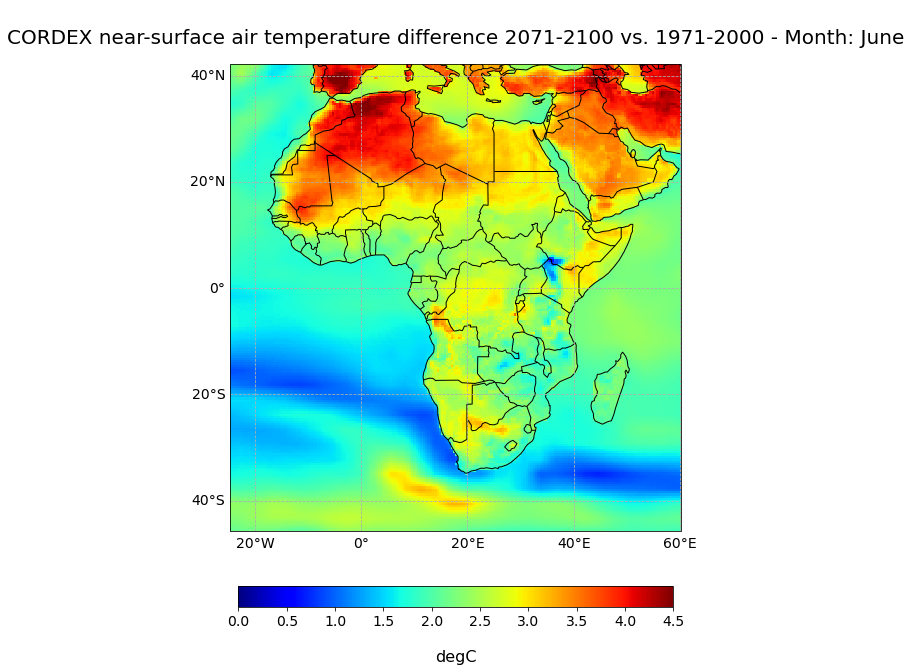

In [19]:
month=5
visualize_pcolormesh(data_array = tas_difference_climatology[month,:,:], 
                     longitude = tas_difference_climatology.rlon, 
                     latitude = tas_difference_climatology.rlat, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'jet', 
                     unit = '\ndegC', 
                     long_name = '\nCORDEX near-surface air temperature difference 2071-2100 vs. 1971-2000 - Month: June', 
                     vmin = 0, 
                     vmax = 4.5, 
                     set_global = False, 
                     lonmin = tas_difference_climatology.rlon.min(), 
                     lonmax = tas_difference_climatology.rlon.max(), 
                     latmin = tas_difference_climatology.rlat.min(), 
                     latmax = tas_difference_climatology.rlat.max())

<br>

As a last step, we repeat the visualization of the difference of the climatology for the period 2071-2100 compared to 1971-2000. But this time, we create the average difference for the whole period. The additional function you have to apply to the data array is to create the average over all months with the function `mean()`.

The visualization of the overall difference between the two reference periods helps you to identify regions in Africa which are likely going to experience a stronger impact of higher temperatures in the future under the moderate scenario RCP4.5.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'\nCORDEX near-surface air temperature difference 2071-2100 vs. 1971-2000'}>)

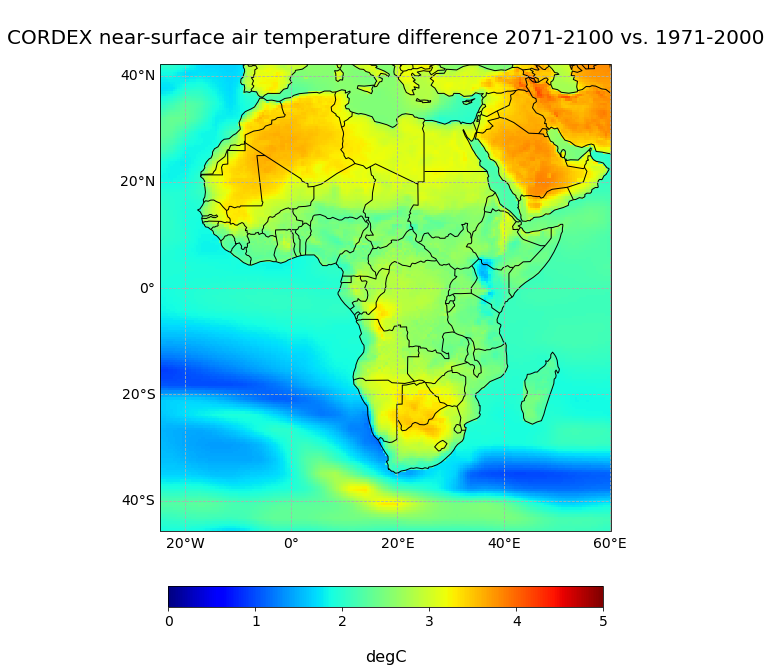

In [20]:
visualize_pcolormesh(data_array = tas_difference_climatology.mean('month'), 
                     longitude = tas_difference_climatology.rlon, 
                     latitude = tas_difference_climatology.rlat, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'jet', 
                     unit = '\ndegC', 
                     long_name = '\nCORDEX near-surface air temperature difference 2071-2100 vs. 1971-2000', 
                     vmin = 0, 
                     vmax = 5, 
                     set_global = False, 
                     lonmin = tas_difference_climatology.rlon.min(), 
                     lonmax = tas_difference_climatology.rlon.max(), 
                     latmin = tas_difference_climatology.rlat.min(), 
                     latmax = tas_difference_climatology.rlat.max())

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>